In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append(os.path.realpath('..'))

In [2]:
import numpy as np
import plotly.express as ex
import pandas as pd
import scipy as sp

from tracking.motion import ConstantVelocityModel
from tracking.space import CartesianPositionVelocity, RbeSpace
from tracking.target import ConstantVelocityTarget
from tracking.util import to_df

## Transform functions

We start by forming function to transform between RBE and Cartesian spaces.

Measurement function transforms the Kalman Filter state into the measurement space.

$$
h(x, y, z) = \left[ \sqrt{x^2+y^2+z^2}, \arctan{\frac{y}{x}}, \arctan{\frac{z}{\sqrt{x^2+y^2}}} \right] = (\rho, \alpha, \epsilon)
$$

In [3]:
def h(cart):
    sq = np.power(cart, 2)
    r  = np.sqrt(sq.sum(axis=0))
    rh = np.sqrt(sq[:, :2].sum(axis=0))

    az = np.arctan2(cart[1, :], cart[0, :])
    el = np.arctan2(cart[2, :], rh)

    rbe = np.array((r, az, el)).T
    return rbe

The inverse of measurement function transforms from the measurement space into the Kalman Filter state (Cartesian) space.

$$
h^{-1}(\rho, \alpha, \epsilon) = \left[ \rho\cos{\epsilon}\cos{\alpha}, \rho\cos{\epsilon}\sin{\alpha}, \rho\sin{\epsilon} \right] = (x, y, z)
$$

In [4]:
def h_inv(rbe):
    r, b, e = rbe[0], rbe[1], rbe[2]
    z = r * np.sin(e)
    x2y2 = r * np.cos(e)
    x = x2y2 * np.cos(b)
    y = x2y2 * np.sin(b)    
    return np.array((x, y, z)).T

We will also need the Jacobian matrix of the measurement function (we will calculate the value of this Jacobian in point $x_0$).

$$
\frac{\partial}{\partial{\bf{x}}} h =
\begin{bmatrix}
    \frac{x}{\sqrt{x^2+y^2+z^2}} & \frac{y}{\sqrt{x^2+y^2+z^2}} & \frac{z}{\sqrt{x^2+y^2+z^2}} \\
    -\frac{y}{x^2+y^2} & \frac{x}{x^2+y^2} & 0 \\
    -\frac{xz}{\sqrt{x^2+y^2}(x^2+y^2+z^2)} & -\frac{yz}{\sqrt{x^2+y^2}(x^2+y^2+z^2)} & \frac{\sqrt{x^2+y^2}}{x^2+y^2+z^2}
\end{bmatrix}
$$

In [5]:
def jacobian(x0):
    x, y, z = x0

    x2y2 = x**2 + y**2
    x2y2z2 = x2y2 + z**2
    
    r = np.sqrt(x2y2z2)
    t = np.sqrt(x2y2)
    u = t * x2y2z2

    # range, bearing, elevation
    return np.array([
        [x/r, y/r, z/r],
        [-y/x2y2, x/x2y2, 0],
        [-x*z/u, -y*z/u, t/x2y2z2]
    ])

## Kalman Filter

Now, using the above transform functions and the Jacobian, we can define the Extended Kalman Filter.

In [6]:
class ExtendedKalmanFilter(object):
    def __init__(self):
        self.state_dim = 6
        self.meas_dim = 3
        self.motion_model = ConstantVelocityModel()

        self.x = np.zeros((self.state_dim, 1)) # column vector
        self.P = np.eye(self.state_dim)

    def initialize(self, z, R):
        z, R = np.array(z).squeeze(), np.array(R).squeeze()
        r, c = R.shape

        assert r == c
        assert r == len(z)
        
        self.x[:3,0] = h_inv(z)

        H = self.H()[:r, :c]
        H = np.linalg.inv(H)
        
        self.P[:r,:c] = H @ R @ H.T
    
    def predict(self, dt):
        F = self.motion_model.F(dt)
        Q = self.motion_model.Q(dt)
        
        self.x = F @ self.x
        self.P = F @ self.P @ F.T + Q

    # measurement matrix
    def H(self):
        J = jacobian(self.x[:3, 0])
        H = np.zeros((self.meas_dim, self.state_dim))
        H[:3, :3] = J
        return H

    def update(self, z, R):
        z = np.array(z); z.shape = (self.meas_dim, 1) # measurement, column vector
        
        z_hat = h(self.x[:3, :])
        z_hat.shape = (self.meas_dim, 1)

        H = self.H()

        # innovation covariance
        # S = H*P*H + R
        S = H @ self.P @ H.T + R

        # Kalman gain
        # K = P*H (H*P*H + R)^-1
        K = self.P @ H.T @ np.linalg.inv(S)

        innovation = z - z_hat
        
        # filtered state (mean)
        # X = X + K(z - H*X)
        x = self.x + K @ innovation
        
        # filtered state (covariance)
        # P = P - K*S*K
        P = self.P - K @ S @ K.T

        self.x = x
        self.P = P

## Test

Simulate a target flying in a straight line, generating RBE detections.

In [7]:
def rbe_measurements(positions, noise_covariance=[10, .1, .1], seed=0):
    rbe = RbeSpace().from_cartesian(positions)
    if noise_covariance is None:
        return rbe
        
    noise_covariance = np.array(noise_covariance)
    if len(noise_covariance.shape) == 1:
        noise_covariance = np.diag(noise_covariance)

    noise_mean = np.full(rbe.shape[1], 0)
    rnd = np.random.default_rng(seed=seed)
    noise = rnd.multivariate_normal(noise_mean, noise_covariance, size=rbe.shape[0])
    assert rbe.shape == noise.shape
    
    return rbe + noise

In [8]:
target = ConstantVelocityTarget(initial_position=[-5000, 1000, 0])
truth = target.true_states()

meas_cov = np.diag([1, 0.0007, 0.0007]) # var=0.0007 rad^2 -> sd = 1.5 deg
measurements = rbe_measurements(truth[:,:3], noise_covariance=meas_cov)

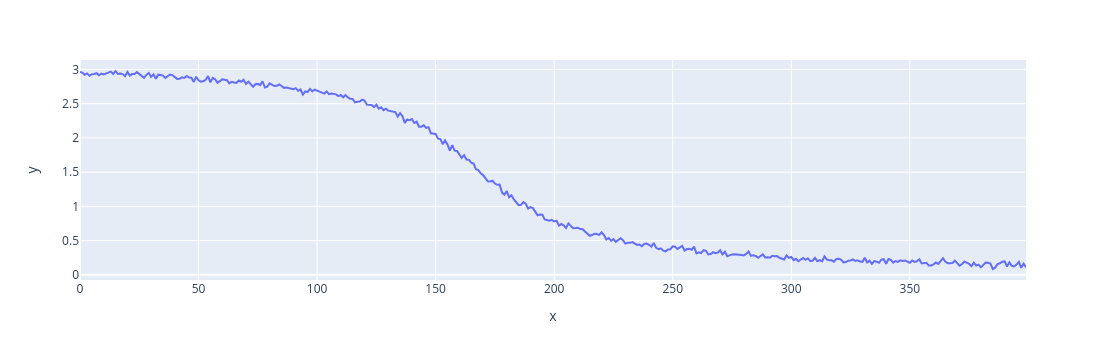

In [9]:
ex.line(y=measurements[:,1])

In [10]:
x_hat, P_hat = [], []

kf = ExtendedKalmanFilter()
kf.initialize(measurements[0,:], meas_cov)

for z in measurements[1:,:]:
    kf.predict(1)

    x_hat.append(np.copy(kf.x))
    P_hat.append(np.copy(kf.P))
    
    kf.update(z, meas_cov)


x_hat, P_hat = np.array(x_hat).squeeze(), np.array(P_hat).squeeze()
meas_cart = RbeSpace().to_cartesian(measurements)

df = pd.concat((to_df(truth).assign(data='truth'), to_df(x_hat).assign(data='est'), to_df(meas_cart).assign(data='meas')))
err = pd.concat((to_df(x_hat-truth[1:,]).assign(data='est'), to_df(meas_cart-truth[:,:3]).assign(data='meas')))

### Truth vs. measurement vs. estimate

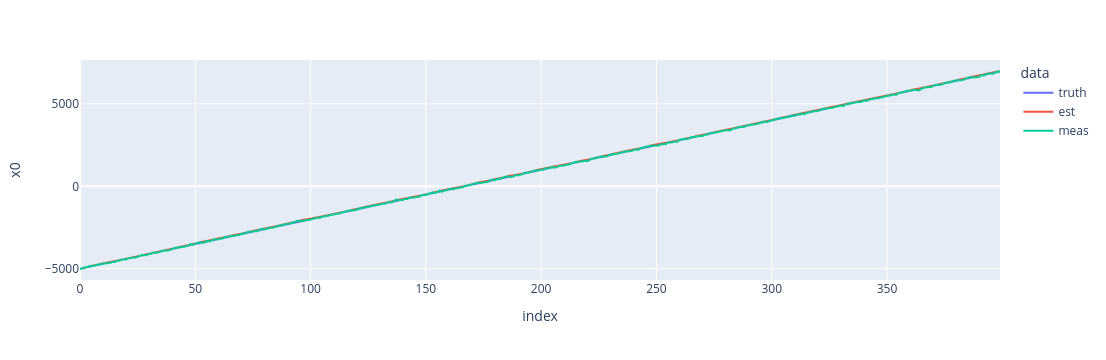

In [11]:
ex.line(df, y='x0', color='data')

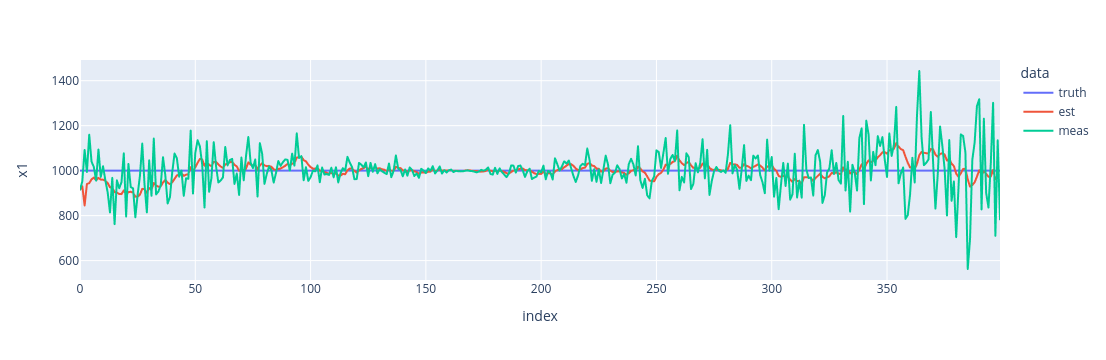

In [12]:
ex.line(df, y='x1', color='data')

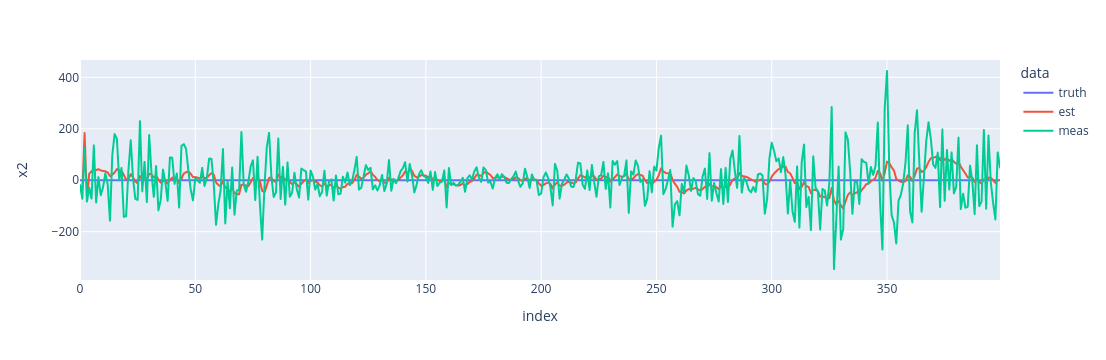

In [13]:
ex.line(df, y='x2', color='data')

### Error: Measurement vs. Estimate

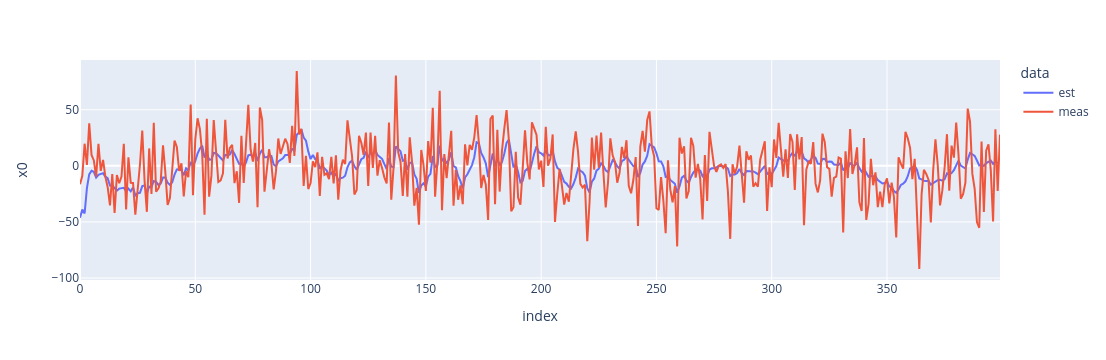

In [14]:
ex.line(err, y='x0', color='data')

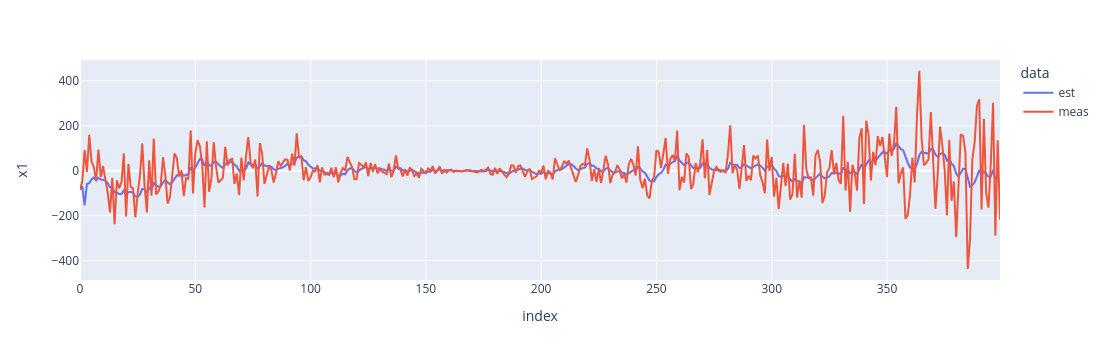

In [15]:
ex.line(err, y='x1', color='data')

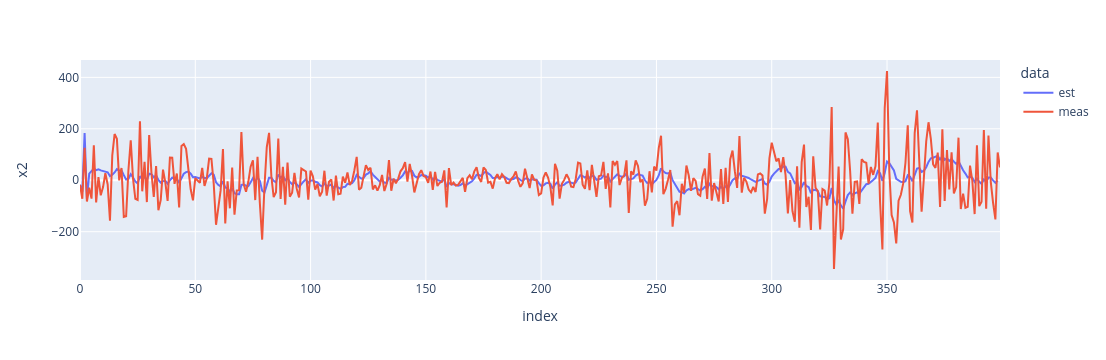

In [16]:
ex.line(err, y='x2', color='data')

### Velocity estimate

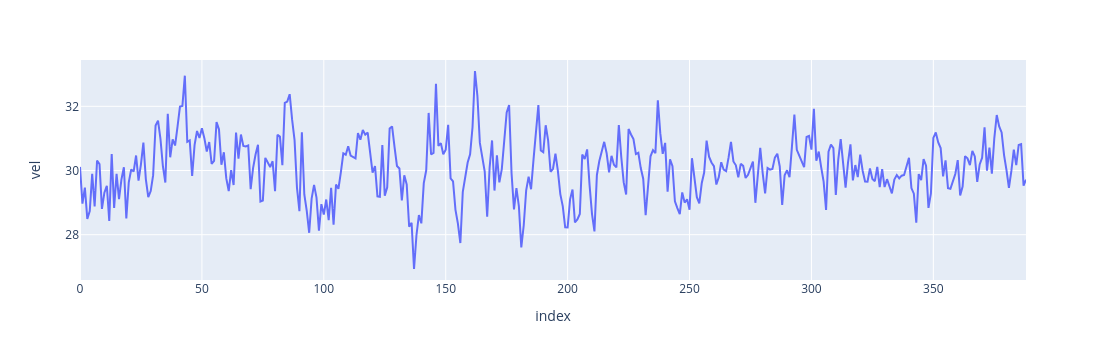

In [17]:
ex.line(to_df(np.linalg.norm(x_hat[10:,3:], axis=1), columns=['vel']), y='vel')

### Histograms of errors

In [18]:
err_m = err.melt(['data'], ['x0', 'x1', 'x2', 'x3', 'x4', 'x5'], 'dim', 'error')

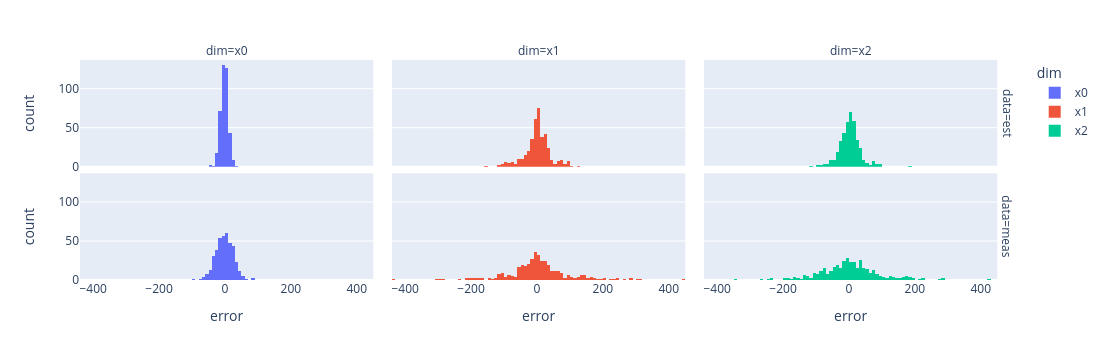

In [19]:
ex.histogram(err_m.query("dim in ['x0', 'x1', 'x2']"), x='error', color='dim', facet_col='dim', facet_row='data')

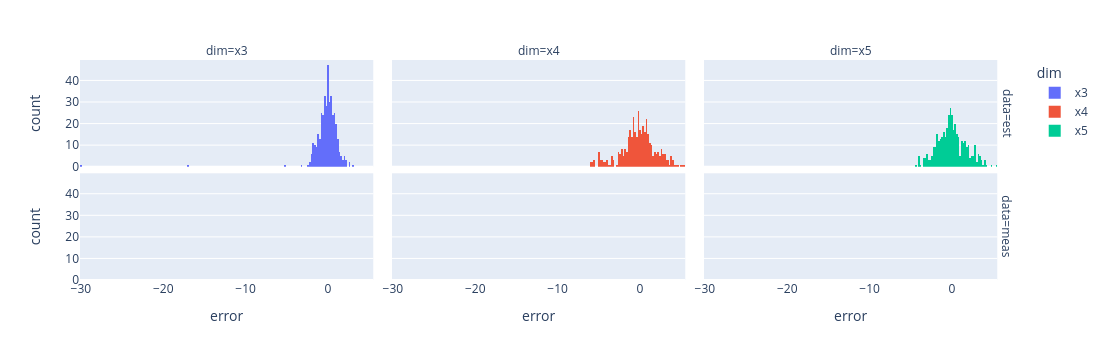

In [20]:
ex.histogram(err_m.query("dim in ['x3', 'x4', 'x5']"), x='error', color='dim', facet_col='dim', facet_row='data')

### Normalized Estimation Error Squared

In [21]:
def nees(truth, x_hat, P_hat):
    d = (x_hat-truth).reshape(-1, x_hat.shape[1], 1)
    P_inv = np.linalg.inv(P_hat)
    return np.matmul(np.matmul(d.transpose(0, 2, 1), P_inv), d).squeeze()

nees_scores = nees(truth[1:,:3], x_hat[:,:3], P_hat[:,:3,:3])

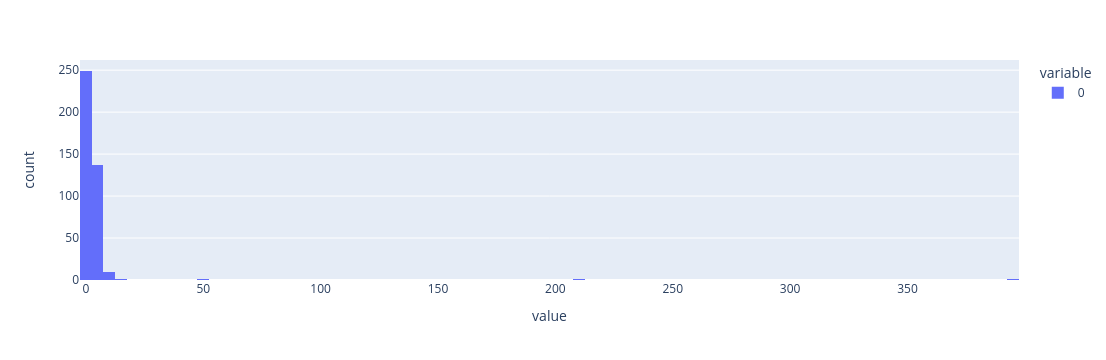

In [22]:
ex.histogram(nees_scores)

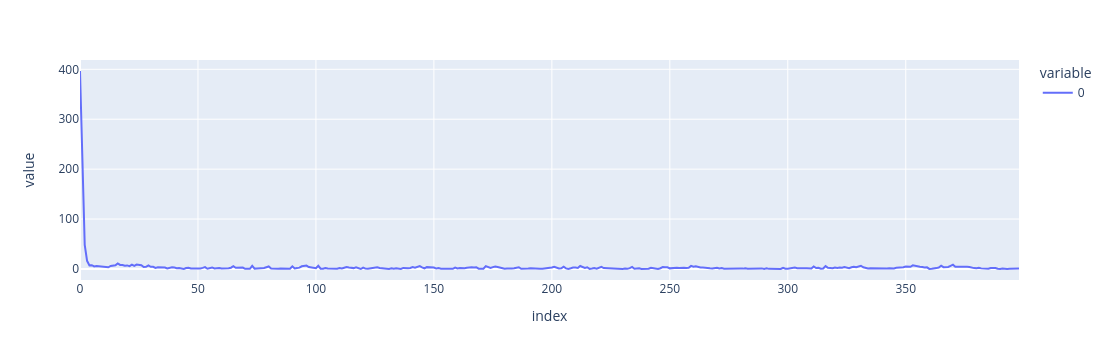

In [23]:
ex.line(nees_scores)

In [24]:
def between(a, x1, x2):
    return (a >= x1) & (a <= x2)


conf_int = sp.stats.chi2.ppf([0.025, 0.975], 3)
between(nees_scores, *conf_int)

array([False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,

We expect 95% of observations to fall within the confidence interval. The number calculated below is fairly close.

In [29]:
np.mean(between(nees_scores, *conf_int))

0.9523809523809523